In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from visturing.properties.prop2 import load_data, load_ground_truth
from visturing.ranking import prepare_data, calculate_correlations_with_ground_truth, calculate_correlations, prepare_and_correlate, prepare_and_correlate_order, calculate_spearman

In [3]:
root_path = "../../Data/Experiment_2"

In [4]:
x, y, x_c, rg, x_c, yb = load_ground_truth("../../ground_truth_decalogo")

In [5]:
x_a, x_rg, x_yb = load_data("../../Data/Experiment_2")

In [6]:
data = {p.split("/")[-1].split(".")[0]: np.load(p) for p in glob(os.path.join(root_path, "*npy")) if "bgs" not in p}
for k, v in data.items():
    print(f"{k}: {v.shape}")

x_yb: (21,)
luminancias: (20,)
yellow_blue: (5, 21, 256, 256, 3)
x_rg: (21,)
red_green: (5, 21, 256, 256, 3)
achrom: (5, 20, 256, 256, 3)


In [7]:
bgs = {p.split("/")[-1].split(".")[0][4:]: np.load(p) for p in glob(os.path.join(root_path, "*npy")) if "bgs" in p}
for k, v in bgs.items():
    print(f"{k}: {v.shape}")

yellow_blue: (5, 256, 256, 3)
achrom: (5, 256, 256, 3)
red_green: (5, 256, 256, 3)


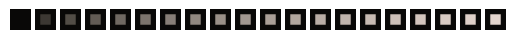

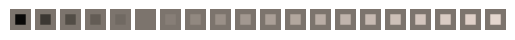

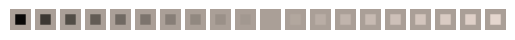

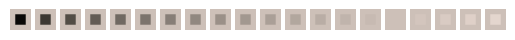

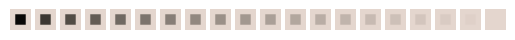

In [8]:
for row in data["achrom"]:
    fig, axes = plt.subplots(1,len(row))
    for ax, s in zip(axes.ravel(), row):
        ax.imshow(s)
        ax.axis("off")
plt.show()

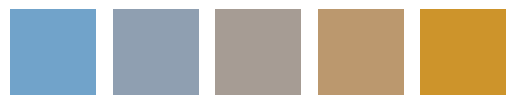

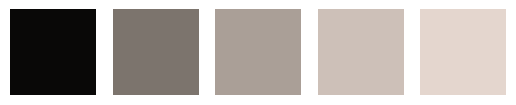

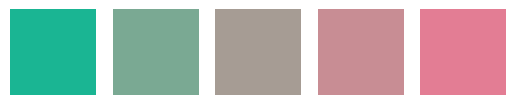

In [9]:
for k, v in bgs.items():
    fig, axes = plt.subplots(1, len(v))
    for ax, s in zip(axes.ravel(), v):
        ax.imshow(s)
        ax.axis("off")
plt.show()

In [10]:
import json

import jax
from jax import random, numpy as jnp
import flax
from huggingface_hub import hf_hub_download
from ml_collections import ConfigDict

from paramperceptnet.models import PerceptNet
from paramperceptnet.configs import param_config

In [11]:
model_name = "ppnet-fully-trained"

In [12]:
config_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                              filename="config.json")
with open(config_path, "r") as f:
    config = ConfigDict(json.load(f))

In [13]:
from safetensors.flax import load_file

weights_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                               filename="weights.safetensors")
variables = load_file(weights_path)
variables = flax.traverse_util.unflatten_dict(variables, sep=".")
state = variables["state"]
params = variables["params"]

In [14]:
model = PerceptNet(config)

In [15]:
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params, **state}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params, **state}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["CenterSurroundLogSigmaK_0"]["__call__"][0][...,1:2]
    b = extra_b["intermediates"]["CenterSurroundLogSigmaK_0"]["__call__"][0][...,1:2]
    return ((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [16]:
params.keys()

dict_keys(['CenterSurroundLogSigmaK_0', 'Color', 'GDNGamma_0', 'GDNGaussian_0', 'GDNSpatioChromaFreqOrient_0', 'GDN_0', 'GaborLayerGammaHumanLike__0', 'LinearScaling_0'])

In [17]:
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params, **state}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params, **state}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["GDNGaussian_0"]["__call__"][0][...,0:1]
    b = extra_b["intermediates"]["GDNGaussian_0"]["__call__"][0][...,0:1]
    return ((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [18]:
diffs = {}
# for c in ["achrom", "red_green", "yellow_blue"]:
for c in ["achrom"]:
    diffs[c] = []
    data_ = data[c]
    bgs_ = bgs[c]
    for cc, bg in zip(data_, bgs_):
        diff = calculate_diffs(cc, cc[0:1])
        diffs[c].append(diff)
diffs = {k: np.array(v) for k, v in diffs.items()}

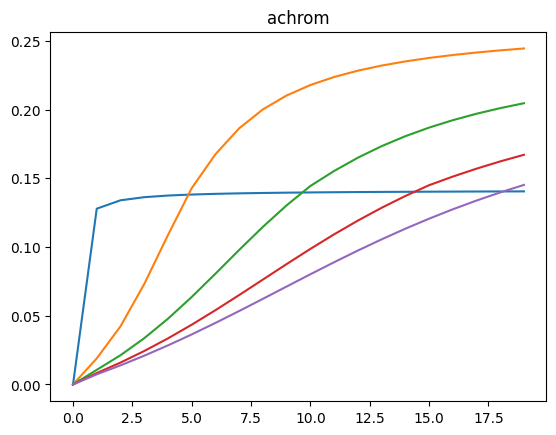

In [19]:
fig, ax = plt.subplots(1,1)
for (k, v) in diffs.items():
    ax.set_title(k)
    for c in v:
        ax.plot(c)
plt.show()

In [36]:
a, b, c, d = prepare_data(x_a, diffs["achrom"], x, y)
print(a.shape, b.shape, c.shape, d.shape)
calculate_spearman(b, ideal_ordering=[0,1,2,3,4])

(20,) (5, 20) (20,) (20,)


{'spearman': np.float64(0.73),
 'kendall': np.float64(0.66125),
 'pearson': np.float64(0.73)}

In [37]:
import scipy.stats as stats
stats.pearsonr(b[0], d)

PearsonRResult(statistic=np.float64(0.7189397815014616), pvalue=np.float64(0.00035450210998772496))

In [21]:
def process(img):
    return (img-img.min())/(img.max()-img.min())

In [22]:
from einops import rearrange

In [23]:
data__ = rearrange(data_, "a b c d e -> (a b) c d e")
data__.shape

(100, 256, 256, 3)

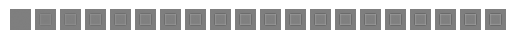

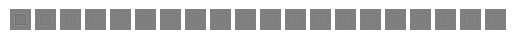

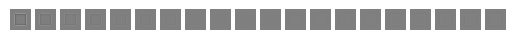

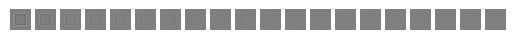

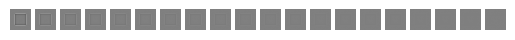

In [24]:
_, extra = model.apply({"params": params, **state}, data__, capture_intermediates=True)
m, M = extra["intermediates"]["CenterSurroundLogSigmaK_0"]["__call__"][0].min(), extra["intermediates"]["CenterSurroundLogSigmaK_0"]["__call__"][0].max()

for cc in data_:
    _, extra = model.apply({"params": params, **state}, cc, capture_intermediates=True)
    fig, axes = plt.subplots(1,20)
    for s, ax in zip(extra["intermediates"]["CenterSurroundLogSigmaK_0"]["__call__"][0], axes.ravel()):
        # ax.imshow(process(s[...,0]), cmap="gray")
        # ax.imshow(s[...,0], cmap="gray", vmin=s.min(), vmax=s.max())
        ax.imshow(s[...,0], cmap="gray", vmin=m, vmax=M)
        ax.axis("off")
    plt.show()

In [25]:
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params, **state}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params, **state}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["GDNGaussian_0"]["__call__"][0][...,1:2]
    b = extra_b["intermediates"]["GDNGaussian_0"]["__call__"][0][...,1:2]
    sign = jnp.sign(a-b).mean(axis=(1,2,3))
    return sign*((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [26]:
# diffs = {}
# for c in ["achrom", "red_green", "yellow_blue"]:
for c in ["red_green"]:
    diffs[c] = []
    data_ = data[c]
    bgs_ = bgs[c]
    for cc, bg in zip(data_, bgs_):
        diff = calculate_diffs(cc, bg[None,...])
        diffs[c].append(diff)
diffs = {k: np.array(v) for k, v in diffs.items()}

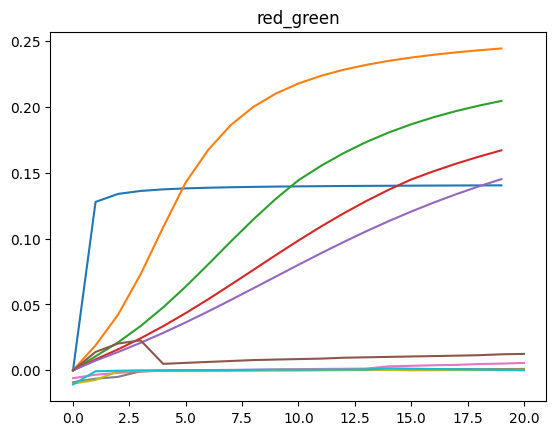

In [27]:
fig, ax = plt.subplots(1,1)
for (k, v) in diffs.items():
    ax.set_title(k)
    for c in v:
        ax.plot(c)
plt.show()

In [28]:
a, b, c, d = prepare_data(x_a, diffs["red_green"], x, y)
print(a.shape, b.shape, c.shape, d.shape)
calculate_spearman(b, ideal_ordering=[0,1,2,3,4])

(20,) (5, 21) (20,) (20,)


{'spearman': np.float64(0.5952380952380952),
 'kendall': np.float64(0.4789115646258504),
 'pearson': np.float64(0.5952380952380952)}

In [29]:
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params, **state}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params, **state}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["GDNGaussian_0"]["__call__"][0][...,2:3]
    b = extra_b["intermediates"]["GDNGaussian_0"]["__call__"][0][...,2:3]
    sign = jnp.sign(a-b).mean(axis=(1,2,3))
    return sign*((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [30]:
# diffs = {}
# for c in ["achrom", "red_green", "yellow_blue"]:
for c in ["yellow_blue"]:
    diffs[c] = []
    data_ = data[c]
    bgs_ = bgs[c]
    for cc, bg in zip(data_, bgs_):
        diff = calculate_diffs(cc, bg[None,...])
        diffs[c].append(diff)
diffs = {k: np.array(v) for k, v in diffs.items()}

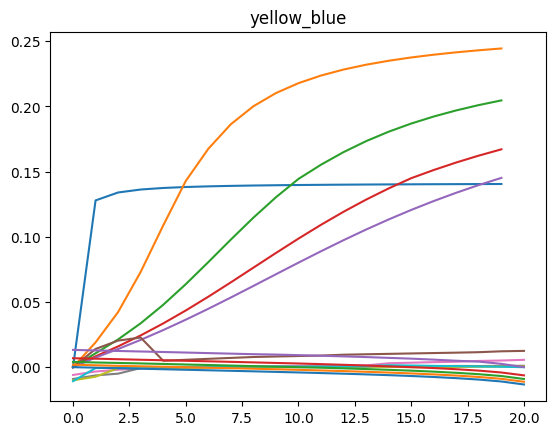

In [31]:
fig, ax = plt.subplots(1,1)
for (k, v) in diffs.items():
    ax.set_title(k)
    for c in v:
        ax.plot(c)
plt.show()

In [32]:
a, b, c, d = prepare_data(x_a, diffs["yellow_blue"], x, y)
print(a.shape, b.shape, c.shape, d.shape)
calculate_spearman(b, ideal_ordering=[0,1,2,3,4])

(20,) (5, 21) (20,) (20,)


{'spearman': np.float64(-1.0),
 'kendall': np.float64(-1.0),
 'pearson': np.float64(-0.9999999999999999)}

In [33]:
a, b_rg, c, d_rg = prepare_data(x_rg, diffs["red_green"], x_c, rg)
b_rg.shape, d_rg.shape

((5, 21), (21,))

In [34]:
a, b_yb, c, d_yb = prepare_data(x_yb, diffs["yellow_blue"], x_c, yb)
b_yb.shape, d_yb.shape

((5, 21), (21,))

In [39]:
import scipy.stats as stats
stats.pearsonr(
    np.concatenate([
        b_rg[2].ravel(), b_yb[2].ravel(),
    ]),
    np.concatenate([
        d_rg.ravel(), d_yb.ravel(),
    ])
)

PearsonRResult(statistic=np.float64(-0.1513364119304953), pvalue=np.float64(0.33871915141005904))